<a href="https://colab.research.google.com/github/sandroklippel/misc_noteboooks/blob/main/Historico_Mapbiomas_de_um_Alerta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Histórico de Uso e Cobertura do Solo de um alerta Mapbiomas

Instruções:

1.   O polígono do alerta será obtido diretamente do servidor Mapbiomas via API portanto será necessário usar as credencias de acesso. Se você não tem uma conta, cadastre-se no site https://plataforma.alerta.mapbiomas.org/sign-up.
2. Preencha o formulário abaixo com essas credenciais, bem como o número do alerta. 
4.   Selecione no menu "Ambiente de execução" -> "Executar tudo" ou pressione Ctrl+F9.
5. Pode ser necessário fazer a autenticação do Earth Engine. Siga as instruções, copie e cole o código no local indicado e tecle [ENTER].
6. O gráfico será gerado na última célula. Há opção para salvá-lo em .PNG.



In [58]:
#@title Dados de entrada { display-mode: "form" }
email = "someone@somewhere" #@param {type:"string"}
senha = "password1234" #@param {type:"string"}
alerta =  12345#@param {type:"integer"}


In [59]:
import ee

try:
  ee.Initialize()
except ee.ee_exception.EEException:
  ee.Authenticate()
  ee.Initialize()

In [60]:
import datetime
import requests
import pandas as pd
import numpy as np
import plotly.express as px

from shapely import wkt
from shapely.geometry import mapping


def busca_alerta(email, senha, alerta):
    """
    Busca o poligono do alerta no servidor Mapbiomas via API
    """

    ENDPOINT = 'https://plataforma.alerta.mapbiomas.org/api/graphql'
    TIMEOUT = 120

    MUTATION = \
    """mutation($email: String!, $password: String!)
       { 
         signIn(email: $email, password: $password)
        {
         token
        }
       }
    """

    QUERY = \
    """
    query
    (
      $alertCode: Int!
      $carId: Int
    )
    {
      alertReport(alertCode: $alertCode, carId: $carId) {
        alertCode
        alertGeomWkt
        areaHa
        }
    }
    """

    credentials = {'email': email, 'password': senha}

    request = requests.post(ENDPOINT, json={'query': MUTATION, 'variables': credentials}, timeout=TIMEOUT)

    if request.status_code == 200:
        result = request.json()
        if 'errors' in result:
            msg = '\n'.join([error['message'] for error in result['errors']])
            raise Exception("Falha na obtenção do alerta. Mensagem retornada: {}.".format(msg))
        else:
            token = result["data"]["signIn"]["token"]
    else:
        raise Exception("Falha na obtenção do alerta. Código retornado: {}.".format(request.status_code))

    headers = {'Authorization': 'Bearer ' + token}

    request = requests.post(ENDPOINT, json={'query': QUERY, 'variables':  {'alertCode': alerta}}, headers=headers, timeout=TIMEOUT)

    if request.status_code == 200:
        row = request.json()
        if 'errors' in row:
            msg = '\n'.join([error['message'] for error in row['errors']])
            raise Exception("Falha na obtenção do alerta. Mensagem retornada: {}.".format(msg))
    else:
        raise Exception("Falha na obtenção do alerta. Código retornado: {}.".format(request.status_code))

    wkt_string = row['data']['alertReport']['alertGeomWkt']
    shapely_geom = wkt.loads(wkt_string)
    return shapely_geom

def map_function(s):
  def mbyr(y):
      k = ee.String('classification_').cat(ee.String(y))
      d = ee.Dictionary(s.get(k))
      return d.set('year', y)
  return mbyr

classes = {3: "Formação Florestal",
           4: "Formação Savânica",
           5: "Mangue",
           9: "Floresta Plantada",
           11: "Área Úmida não Florestal",
           12: "Formação Campestre",
           13: "Outra Formação Natural não Florestal",
           15: "Pastagem",
           18: "Agricultura",
           19: "Cultura Anual e Perene",
           20: "Cultura Semi-Perene",
           21: "Mosaico de Agricultura e Pastagem",
           23: "Praia e Duna",
           24: "Infraestrutura Urbana",
           25: "Outra Área não Vegetada",
           27: "Não observado",
           29: "Afloramento Rochoso",
           30: "Mineração",
           31: "Aquicultura",
           33: "Rio, Lago e Oceano",
           32: "Apicum",
           34: "Glacias",
           36: "Lavoura Perene",
           39: "Soja",
           40: "Arroz",
           41: "Outras Lavouras Temporárias",
           46: "Café",
           47: "Citrus",
           48: " Outras Lavouras Perene",
           49: "Restinga Arborizad"}

cores = {3: "#274e13",
         4: "#32cd32",
         5: "#687537",
         9: "#935132",
        11: "#45c2a5",
        12: "#b8af4f",
        13: "#bdb76b",
        15: "#ffd966",
        18: "#e974ed",
        19: "#d5a6bd",
        20: "#c27ba0",
        21: "#ffefc3",
        23: "#dd7e6b",
        24: "#af2a2a",
        25: "#ff99ff",
        27: "#d5d5e5",
        29: "#ff8c00",
        30: "#8a2be2",
        31: "#29eee4",
        33: "#0000ff",
        32: "#968c46",
        34: "#968c46",
        36: "#f3b4f1",
        39: "#e075ad",
        40: "#982c9e",
        41: "#e787f8",
        46: "#cca0d4",
        47: "#d082de",
        48: "#cd49e4",
        49: "6b9932"}

color_map = {classes[k]: v for k, v in cores.items()}

shapely_geom = busca_alerta(email, senha, alerta)
geojson = mapping(shapely_geom)

hoje = datetime.datetime.today().strftime('%d/%m/%Y')
geom = ee.Geometry(geojson)
area_ha = geom.area().getInfo() / 10000.0

mapbiomas = ee.Image('projects/mapbiomas-workspace/public/collection6/mapbiomas_collection60_integration_v1')

stats = (mapbiomas.reduceRegion(
         reducer = ee.Reducer.frequencyHistogram(),
        geometry = geom,
        scale = 30,
        crs = 'EPSG:4326'
        ))

years = ee.List([str(i) for i in range(1985,2021)])

map_by_year = map_function(stats)

lst = years.map(map_by_year)

df = pd.DataFrame(lst.getInfo())
df.set_index('year', inplace=True)
df_perc = df.div(df.iloc[0,:].sum(), axis=1).mul(100).round(2)
df_perc.columns = [classes[int(c)] for c in df_perc.columns.tolist()]

In [61]:
fig = px.bar(df_perc, barmode='stack', 
             color_discrete_map=color_map, 
             labels={"value": "% da área do polígono", "variable": "", "year": ""},
             title=f"Alerta {alerta} ({area_ha:.2f} ha) - Histórico de Uso e Cobertura do Solo")

fig.update_layout(template='simple_white')
fig.update_xaxes(tickangle=-90)
fig.add_annotation(
    text = f"Fonte dos dados: Projeto MapBiomas – Coleção 6 da Série Anual de Mapas de Uso e Cobertura da Terra do Brasil, acesso em {hoje}.",
    showarrow=False,
    x = 0,
    y = -0.2,
    xref='paper',
    yref='paper',
    xanchor='left',
    yanchor='bottom',
    xshift=-1,
    yshift=-5,
    font=dict(size=10, color="grey"),
    align="left")
fig.show()

### Polígono para simples conferência:

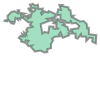

In [62]:
shapely_geom